In [1]:
import nltk
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetimeS
import matplotlib.pyplot as plt


In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Load the data
file_path = "Clasico.txt"
df = pd.read_csv(file_path, sep=r'\$\|', header=None, names=["TweetID", "Tweet_Text", "DateTime", "Location"], engine="python")
df

,TweetID,Tweet_Text,DateTime,Location
0,0,Barcelona now have the same number of wins as...,2019-02-27 23:59:57,b''$$
1,1,El Clasico Record 241 Games 95 RealMadrid Win...,2019-02-27 23:59:56,b'Rio de janeiro'$$
2,2,Ousmane Dembele El Clasico stats Games 2 Goal...,2019-02-27 23:59:44,b'camp-nou'$$
3,3,Mandatory Clasico stat Sergio Ramos extends h...,2019-02-27 23:59:42,b'Germany - \xf0\x9f\x87\xac\xf0\x9f\x87\xad'$$
4,4,That s how you take a pen in a Cl sico My word,2019-02-27 23:59:39,b''$$
...,...,...,...,...
1525,1525,So far this Clasico is the most disappointing ...,2019-02-27 20:56:43,"b'Quetta, Pakistan'$$"
1526,1526,MHafeez22 Wavoo You gona for El clasico,2019-02-27 20:56:12,"b'Bagh Azad kashmir,Pakistan'$$"
1527,1527,BPL or die but el Cl sico over anything and ev...,2019-02-27 20:56:11,"b'Fort Lauderdale, FL'$$"
1528,1528,few things i take from the first half 1 clasic...,2019-02-27 20:56:09,b''$$


In [4]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import MinMaxScaler


def clean_and_preprocess(text):
    if pd.isnull(text):
        return ""

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^A-Za-z]+', ' ', text)

    text = text.lower()

    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    cleaned_text = ' '.join(stemmed_tokens)

    return cleaned_text

df["Tweet_Text"] = df["Tweet_Text"].apply(clean_and_preprocess)


In [5]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Tweet_Text'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [6]:
# Function to calculate time closeness in seconds
def calculate_time_closeness(datetime1, datetime2):
    format_str = "%Y-%m-%d %H:%M:%S"
    dt1 = datetime.strptime(datetime1, format_str)
    dt2 = datetime.strptime(datetime2, format_str)
    time_difference = abs((dt2 - dt1).total_seconds())
    return time_difference

In [7]:
from datetime import datetime

def calculate_time_closeness(datetime1, datetime2):
    datetime1 = pd.to_datetime(datetime1)
    datetime2 = pd.to_datetime(datetime2)

    time_difference = abs((datetime2 - datetime1).total_seconds())

    max_time_difference = 60.0 * 24.0 * 60.0
    time_closeness = 1.0 - min(time_difference / max_time_difference, 1.0)

    return time_closeness

In [8]:
text_similarity = cosine_sim[1, 2]
datetime1 = pd.to_datetime(df["DateTime"].iloc[1])
datetime2 = pd.to_datetime(df["DateTime"].iloc[2])
time_closeness = calculate_time_closeness(datetime1, datetime2)
combined_score =  text_similarity * time_closeness
combined_score

0.16343297006379165

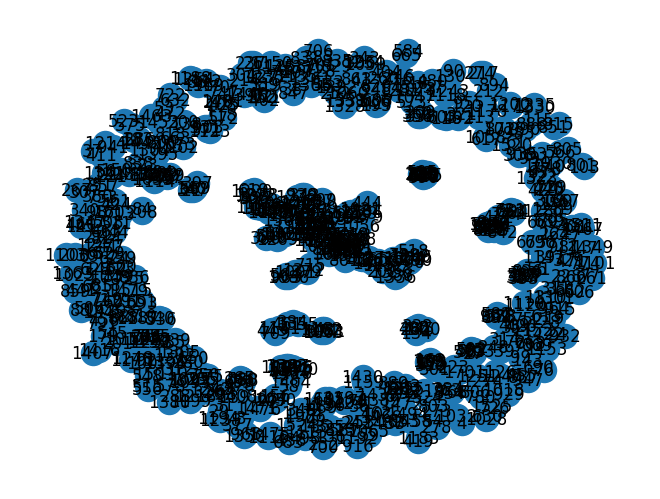

In [37]:
# Create a weighted graph
G = nx.Graph()

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        text_similarity = cosine_sim[i, j]
        datetime1 = pd.to_datetime(df["DateTime"].iloc[i])
        datetime2 = pd.to_datetime(df["DateTime"].iloc[j])
        time_closeness = calculate_time_closeness(datetime1, datetime2)
        combined_score =  text_similarity * time_closeness
        if combined_score > 0.5:
            edge_weight = round(combined_score,1)
            G.add_edge(df['TweetID'][i], df['TweetID'][j], weight=edge_weight)


# Visualize the graph (optional)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


## k core

[0, 8, 17, 533, 22, 23, 537, 27, 1051, 1057, 550, 1063, 43, 1074, 1075, 65, 1089, 579, 68, 590, 592, 595, 597, 620, 621, 1149, 642, 644, 1162, 155, 162, 165, 1191, 189, 190, 199, 1240, 220, 238, 1292, 784, 795, 293, 310, 327, 843, 1358, 1362, 854, 1375, 353, 1383, 1387, 1390, 880, 897, 1411, 1415, 913, 918, 1432, 921, 1436, 415, 928, 1441, 1456, 950, 1473, 974, 977, 468, 980, 985, 493, 1517, 499, 507]


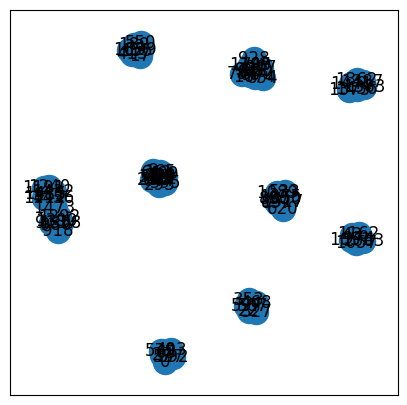

In [10]:
k_cores_G = nx.k_core(G, k=5)
print(k_cores_G.nodes())
plt.figure(figsize=(5, 5))
nx.draw_networkx(k_cores_G, with_labels=True)
plt.show()

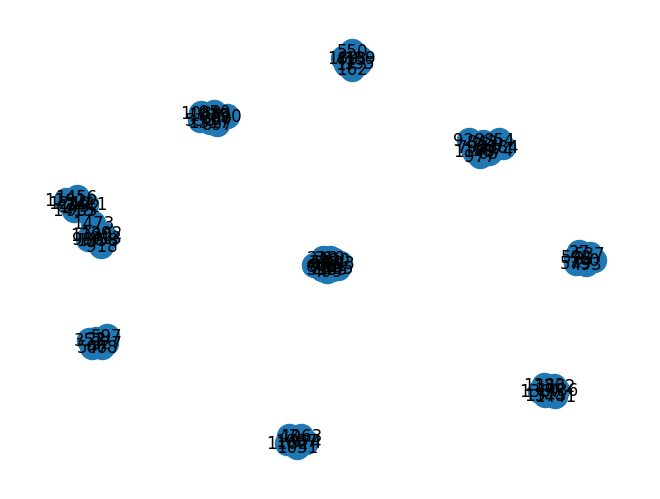

In [11]:
min_common_neighbors = 3
new_G = nx.Graph()

for edge in k_cores_G.edges():
    node1, node2 = edge #tuple unpacking
    if G.has_edge(node1, node2):
      neighbors1 = set(k_cores_G.neighbors(node1))
      neighbors2 = set(k_cores_G.neighbors(node2))

      common_neighbors = neighbors1.intersection(neighbors2)

      if len(common_neighbors) >= min_common_neighbors:
          new_G.add_edge(node1, node2)

nodes_to_remove = [node for node in new_G.nodes() if len(set(new_G.neighbors(node))) < min_common_neighbors]

new_G.remove_nodes_from(nodes_to_remove)

pos_new = nx.spring_layout(new_G)
nx.draw(new_G, pos_new, with_labels=True)
labels_new = nx.get_edge_attributes(new_G, 'weight')
nx.draw_networkx_edge_labels(new_G, pos_new, edge_labels=labels_new)
plt.show()

In [12]:
connected_nodes_dict = {}

for edge in new_G.edges():
    if edge[0] in connected_nodes_dict:
        connected_nodes_dict[edge[0]].append(edge[1])
    else:
        connected_nodes_dict[edge[0]] = [edge[1]]

    if edge[1] in connected_nodes_dict:
        connected_nodes_dict[edge[1]].append(edge[0])
    else:
        connected_nodes_dict[edge[1]] = [edge[0]]

for node, connected_nodes in connected_nodes_dict.items():
    print(f"Node {node} is connected to nodes: {connected_nodes}")


Node 0 is connected to nodes: [27, 65, 493, 537, 579, 592]
Node 27 is connected to nodes: [0, 537, 65, 493, 579, 592]
Node 65 is connected to nodes: [0, 27, 537, 493, 579, 592]
Node 493 is connected to nodes: [0, 27, 65, 537, 579, 592]
Node 537 is connected to nodes: [0, 27, 65, 493, 579, 592]
Node 579 is connected to nodes: [0, 27, 65, 493, 537, 592]
Node 592 is connected to nodes: [0, 27, 65, 493, 537, 579]
Node 8 is connected to nodes: [23, 165, 190, 238, 310, 499, 590, 621, 642, 644]
Node 23 is connected to nodes: [8, 165, 190, 238, 293, 310, 499, 590, 595, 621, 642, 644]
Node 165 is connected to nodes: [8, 23, 590, 595, 621, 642, 644, 190, 238, 293, 310, 499]
Node 190 is connected to nodes: [8, 23, 165, 590, 595, 621, 642, 644, 238, 293, 310, 499]
Node 238 is connected to nodes: [8, 23, 165, 190, 590, 595, 621, 642, 644, 293, 310, 499]
Node 310 is connected to nodes: [8, 23, 165, 190, 238, 590, 595, 621, 642, 644, 293, 499]
Node 499 is connected to nodes: [8, 23, 165, 190, 238, 31

In [40]:
communities = []

# Print the connected nodes for each node and store communities
for node, connected_nodes in connected_nodes_dict.items():
    community = [(node, df.at[node, 'Tweet_Text'])] + [(n, df.at[n, 'Tweet_Text']) for n in connected_nodes]
    communities.append(community)

# Write communities to a text file
output_file_path = "k_core_communities.txt"
with open(output_file_path, 'w', encoding='utf-8') as output_file:
    for community in communities:
        community_line = '\n'.join([f"{tweet_id}: {tweet_text}" for tweet_id, tweet_text in community])
        output_file.write(community_line + '\n\n')

In [41]:
# Get the connected components (communities)
communities_kcore = list(nx.connected_components(new_G))

# Print community sizes
print("Community Sizes:")
for i, community in enumerate(communities_kcore, 1):
    print(f"Community {i}: Size {len(community)}")

Community Sizes:
Community 1: Size 7
Community 2: Size 13
Community 3: Size 7
Community 4: Size 8
Community 5: Size 6
Community 6: Size 6
Community 7: Size 11
Community 8: Size 14
Community 9: Size 6


In [52]:
connected_nodes_dict2 = {}

for edge in G.edges():
    if edge[0] in connected_nodes_dict2:
        connected_nodes_dict2[edge[0]].append(edge[1])
    else:
        connected_nodes_dict2[edge[0]] = [edge[1]]

    if edge[1] in connected_nodes_dict2:
        connected_nodes_dict2[edge[1]].append(edge[0])
    else:
        connected_nodes_dict2[edge[1]] = [edge[0]]

In [54]:
communities2 = []

# Print the connected nodes for each node and store communities
for node, connected_nodes in connected_nodes_dict2.items():
    community = [(node, df.at[node, 'Tweet_Text'])] + [(n, df.at[n, 'Tweet_Text']) for n in connected_nodes]
    communities2.append(community)


## **k truss**

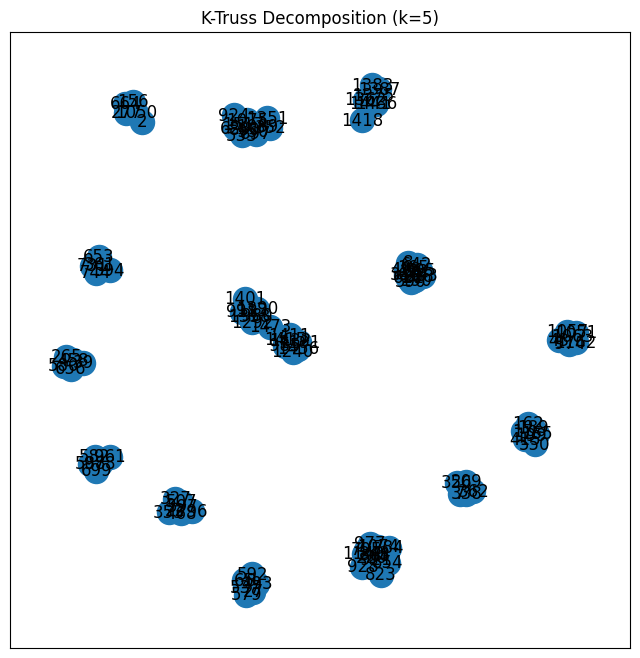

In [87]:
k_truss_G = nx.k_truss(G, k=5)

plt.figure(figsize=(8, 8))
nx.draw_networkx(k_truss_G, with_labels=True)
plt.title("K-Truss Decomposition (k=5)")
plt.show()


In [90]:
connected_nodes_dict3 = {}

for edge in k_truss_G.edges():
    if edge[0] in connected_nodes_dict3:
        connected_nodes_dict3[edge[0]].append(edge[1])
    else:
        connected_nodes_dict2[edge[0]] = [edge[1]]

    if edge[1] in connected_nodes_dict3:
        connected_nodes_dict3[edge[1]].append(edge[0])
    else:
        connected_nodes_dict3[edge[1]] = [edge[0]]
communities3= []

# Print the connected nodes for each node and store communities
for node, connected_nodes in connected_nodes_dict3.items():
    community = [(node, df.at[node, 'Tweet_Text'])] + [(n, df.at[n, 'Tweet_Text']) for n in connected_nodes]
    communities3.append(community)


In [97]:
from networkx.algorithms.community.quality import modularity

communities_ktruss_list = list(nx.community.greedy_modularity_communities(k_truss_G, weight='weight'))
kcore_modularity = modularity(k_truss_G, communities_ktruss_list, weight='weight')

print(f"K-Core Modularity: {kcore_modularity}")


K-Core Modularity: 0.88749147086745


## **girvan newman**

In [14]:
import itertools
com = nx.community.girvan_newman(G)
for communities in itertools.islice(com, 6):
 print(tuple(sorted(c) for c in communities))


([0, 27, 65, 493, 537, 579, 592], [1, 22, 56, 327, 353, 468, 507, 597, 796, 826], [2, 156, 277, 664, 1050], [3, 377], [4, 1032], [6, 69], [7, 209, 338, 356, 362], [8, 23, 165, 190, 238, 293, 310, 499, 590, 595, 621, 642, 644], [10, 462], [11, 140, 347, 397, 569], [13, 73, 126, 127, 139, 154, 229, 308, 342, 367, 386, 399, 432, 442, 444, 483, 599, 619, 625, 637, 640, 679, 740, 853, 896, 913, 917, 918, 927, 939, 958, 976, 980, 985, 1003, 1009, 1012, 1021, 1034, 1048, 1055, 1078, 1079, 1087, 1100, 1105, 1106, 1132, 1134, 1139, 1156, 1182, 1191, 1207, 1210, 1212, 1220, 1240, 1267, 1269, 1290, 1292, 1297, 1352, 1358, 1367, 1368, 1370, 1390, 1394, 1401, 1405, 1409, 1411, 1415, 1417, 1423, 1426, 1432, 1456, 1473, 1488], [17, 155, 162, 189, 199, 301, 415, 550], [18, 1073], [19, 613], [24, 932], [25, 460], [26, 237], [29, 31], [30, 578], [33, 1053], [35, 409, 426, 1152, 1422], [36, 78, 231], [37, 411], [38, 847], [39, 265, 458, 478, 580, 656], [41, 863], [43, 974, 1051, 1057, 1063, 1162], [45, 1

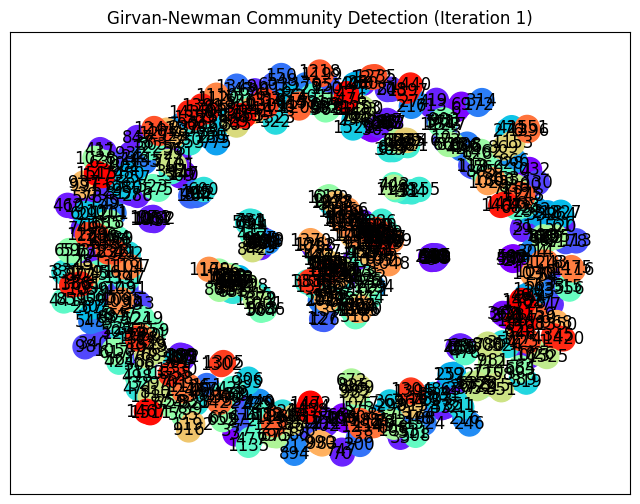

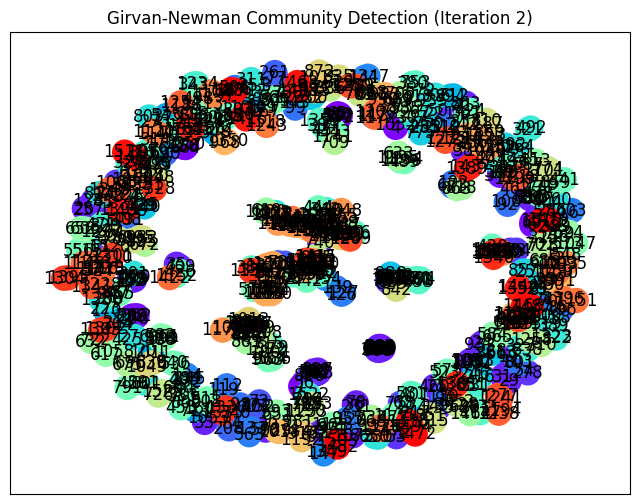

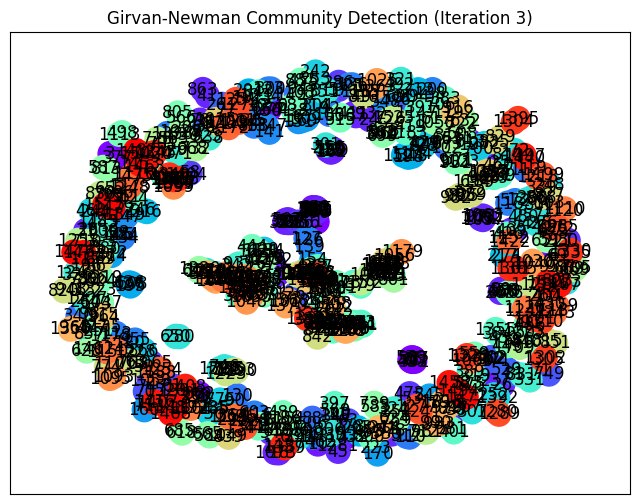

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

# Apply Girvan-Newman algorithm
girvan_newman = nx.community.girvan_newman(G)

# Get communities for the first 3 iterations
for i, communities in enumerate(itertools.islice(girvan_newman, 3)):
    communities = tuple(sorted(c) for c in communities)

    # Set color for each community
    node_colors = defaultdict(int)
    c_count = 0

    for c in communities:
        for node in c:
            node_colors[node] = c_count
        c_count += 1

    plt.figure(figsize=(8, 6))
    nx.draw_networkx(
        G,
        with_labels=True,
        node_color=list(node_colors.values()),
        cmap=plt.cm.rainbow,  # You can change the color map as needed
    )
    plt.title(f"Girvan-Newman Community Detection (Iteration {i + 1})")
    plt.show()


# louvain

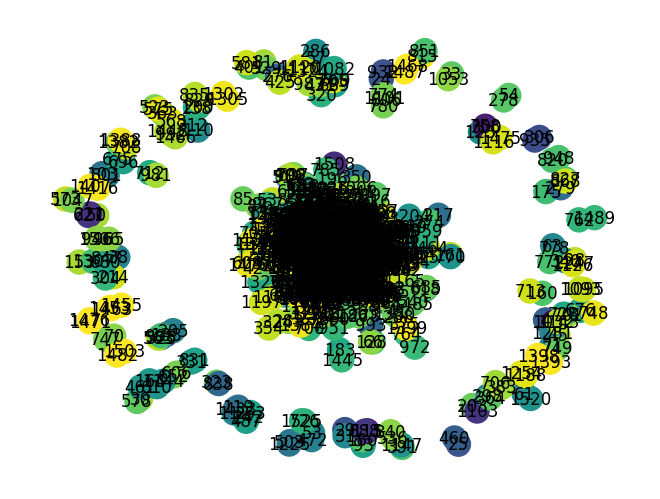

In [21]:
import community

communities_list = communities2

# Convert the communities list to a dictionary for Louvain partitioning
louvain_partition_dict = {node: i for i, comm in enumerate(communities_list) for node, _ in comm}

# Add the Louvain partition as a node attribute
nx.set_node_attributes(G, louvain_partition_dict, 'louvain_community')

# Visualize the Louvain clustering
pos_louvain = nx.spring_layout(G)
nx.draw(G, pos_louvain, with_labels=True, node_color=list(louvain_partition_dict.values()))
plt.show()

In [63]:
!pip install python-louvain --upgrade


In [65]:
!pip install louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.5 MB/s eta 0:00:00


In [86]:
import community
import louvain

In [59]:
# 2. Community Size Distribution
community_sizes_k_core = [len(community) for community in communities]
community_sizes_louvain = [len(community) for community in communities_list]
print(" Communities sizes:")
print(f"K-Core: {community_sizes_k_core}")
print(f"Louvain: {community_sizes_louvain}")

 Communities sizes:
K-Core: [7, 7, 7, 7, 7, 7, 7, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 7, 7, 6, 7, 7, 7, 6, 7, 8, 8, 8, 8, 7, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 10, 10, 11, 6, 9, 11, 6, 11, 8, 9, 6, 7, 8, 7, 8, 8, 8, 7, 10, 7, 7, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6]
Louvain: [19, 26, 28, 13, 25, 27, 32, 28, 15, 21, 33, 24, 44, 13, 20, 33, 22, 42, 32, 6, 24, 17, 21, 20, 43, 25, 23, 16, 47, 42, 6, 8, 8, 14, 6, 17, 8, 19, 5, 8, 6, 8, 8, 15, 11, 17, 32, 5, 33, 5, 22, 35, 36, 23, 22, 29, 6, 25, 16, 25, 17, 17, 17, 7, 6, 6, 7, 9, 13, 9, 7, 9, 3, 5, 16, 41, 41, 41, 4, 6, 2, 4, 15, 2, 7, 5, 7, 7, 2, 39, 38, 35, 6, 6, 7, 42, 42, 17, 55, 31, 18, 15, 40, 2, 23, 23, 50, 50, 8, 21, 8, 7, 9, 6, 28, 9, 10, 18, 4, 14, 7, 9, 7, 7, 26, 33, 18, 46, 15, 8, 11, 11, 22, 15, 6, 6, 13, 14, 21, 26, 8, 9, 22, 7, 8, 7, 23, 16, 21, 24, 3, 11, 18, 17, 10, 19, 8, 17, 24, 14, 8, 18, 15, 15, 14, 17, 14, 15, 16, 17, 12, 26, 6, 6, 3, 9, 3, 4, 4, 3, 3, 3, 3, 5, 11, 2, 3, 2, 6, 6, 17, 3, 4, 9, 10, 4, 13, 1

In [85]:
import community
from networkx.algorithms.community import modularity
from community import community_louvain
import itertools
from networkx.algorithms.community.quality import modularity
# Convert k-core communities to the required format
communities_kcore_list = list(communities_kcore)

# 1. Modularity for K-Core
modularity_k_core = modularity(new_G, communities_kcore_list)
print(f"Modularity for K-Core: {modularity_k_core}")


# 3. Modularity for Girvan-Newman
girvan_newman_partition = list(itertools.islice(nx.community.girvan_newman(G), 1))[0]
modularity_girvan_newman = modularity(G, girvan_newman_partition)
print(f"Modularity for Girvan-Newman: {modularity_girvan_newman}")


Modularity for K-Core: 0.8445442134005461
Modularity for Girvan-Newman: 0.9416243231986714
